In [1]:
import sympy as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

1300000


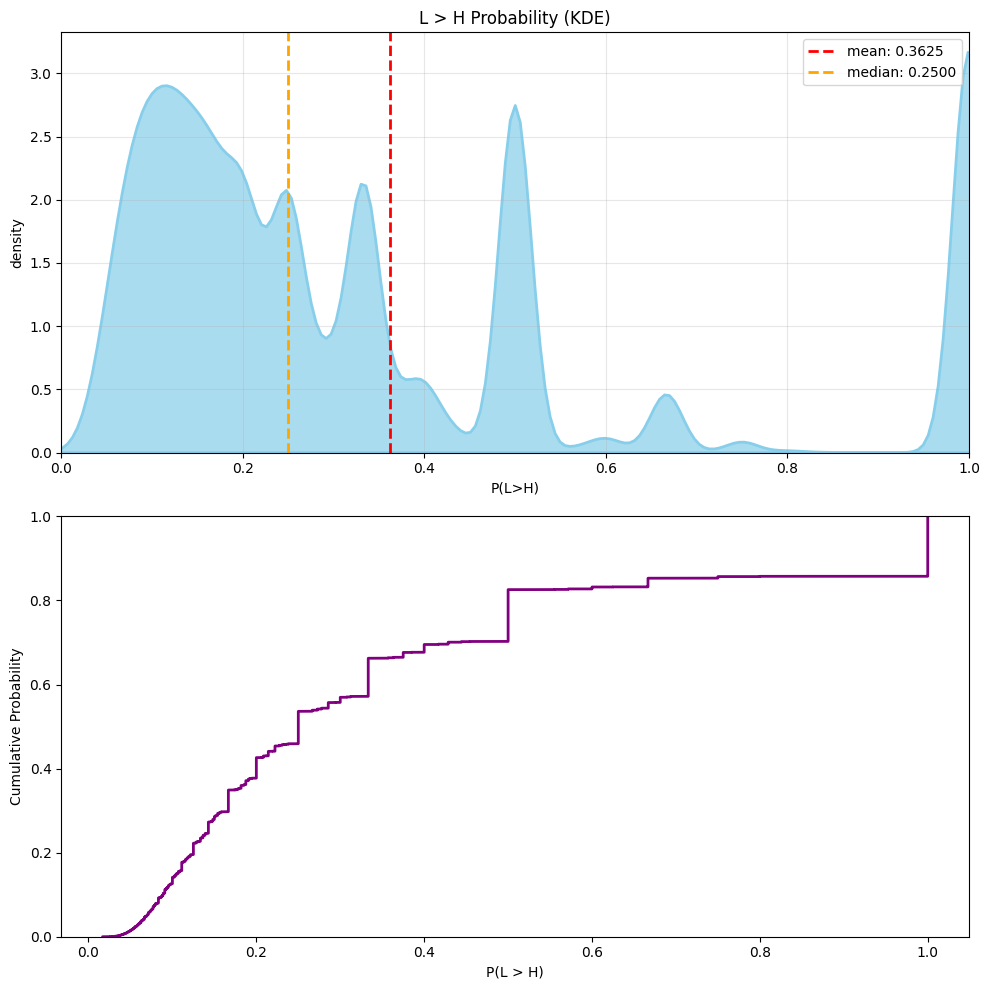

95% for lambda=1 and alpha=0.05: (0.016746, 1.000000)


In [156]:
def generate_sequences_until_h_minimal(L_probs: Dict, H_probs: Dict, W_probs: Dict) -> Tuple[List[Dict],float]: #Create one sample sequence and calculate corresponding P(L >H)

    L_values = list(L_probs.keys())
    L_prob_list = list(L_probs.values())

    H_values = list(H_probs.keys())
    H_prob_list = list(H_probs.values())

    W_values = list(W_probs.keys())
    W_prob_list = list(W_probs.values())

    sequences = []

    while True:
        T_i=0
        J_i=0
        # generate random l,h,w independently
        l = np.random.choice(L_values, p=L_prob_list,replace= True)
        h = np.random.choice(H_values, p=H_prob_list,replace= True)
        w = np.random.choice(W_values, p=W_prob_list,replace= True)
        if l < h and l < w:
            T_i, J_i=l, 1
        elif h < l and h < w:
            T_i, J_i=h, 2
        else:
            T_i, J_i=w, 3
        sample={'T_i': T_i, 'J_i': J_i}
        #print("T_i=",T_i,"J_i=",J_i)
        sequences.append(sample)
        # break if the husband dies
        if J_i == 2:
            break
    # Calculate P(L > H)
    N=len(sequences)
    N_8 = len([sample for sample in sequences if sample['T_i']==8])
    N_Q = len([sample for sample in sequences if sample['J_i']==3])
    N_M = 1 # By our setting, N_M is always 1
    prob = (N_M*(N_8+N_M+N_Q))/(N*(N_8+N_M))
    #print(prob)
    return sequences,prob


def run_multiple_simulations(n_simulations: int = 10000) -> np.ndarray: #Bootstrap function, n_simulations for number of Bootstrap samples B
    # Empirical Probability Distributions
    L_probabilities = {1: 1 / 4, 2: 1 / 8, 3: 1 / 8, 5: 1 / 8, 8: 3 / 16, 100: 3 / 16} #100 for > 27
    H_probabilities = {27: 1}
    W_probabilities = {7: 1 / 3, 100: 2 / 3}

    probabilities = []

    for i in range(n_simulations):
        _, prob = generate_sequences_until_h_minimal(
            L_probabilities, H_probabilities, W_probabilities
        )

        probabilities.append(prob)
    return np.array(probabilities)

def plot_probability_density(probabilities: np.ndarray):
    """
    绘制概率密度函数图像
    """

    # 创建子图
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # 1. 密度图 (KDE)

    sns.kdeplot(probabilities, ax=ax1, fill=True, alpha=0.7, color='skyblue', linewidth=2)
    ax1.axvline(probabilities.mean(), color='red', linestyle='--', linewidth=2,
                label=f'mean: {probabilities.mean():.4f}')
    ax1.axvline(np.median(probabilities), color='orange', linestyle='--', linewidth=2,
                label=f'median: {np.median(probabilities):.4f}')

    ax1.set_xlabel(r'P(L>H)')
    ax1.set_ylabel('density')
    ax1.set_title('L > H Probability (KDE)')
    ax1.set_xlim(0, 1)  # 强制x轴范围在0-1之间
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # # 2. 直方图 + 密度曲线
    # sns.histplot(probabilities, kde=True, ax=ax2, alpha=0.7, color='lightgreen',
    #              stat='density', bins=30)
    # ax2.axvline(probabilities.mean(), color='red', linestyle='--', linewidth=2,
    #             label=f'mean: {probabilities.mean():.4f}')

    # ax2.set_xlabel('probability')
    # ax2.set_ylabel('density')
    # ax2.set_title('L > H ')
    # ax2.legend()
    # ax2.grid(True, alpha=0.3)
    
    # 3. 累积分布函数 (CDF)
    sns.ecdfplot(probabilities, ax=ax2, color='purple', linewidth=2)
    ax2.set_xlabel(r'P(L > H)')
    ax2.set_ylabel('Cumulative Probability')  

    plt.tight_layout()
    plt.show()

   # 置信区间
    # 定义要计算的分位数（2.5% 和 97.5%）
    lambda_=1
    alpha=.05
    quantiles = [(1-lambda_)*alpha, 1-lambda_*alpha]
    # 计算分位数（interpolation='linear' 是默认值，适合连续数据；若为离散概率，可保留默认）
    lower, upper = np.quantile(probabilities, quantiles)

    # 输出结果（保留6位小数，和你之前的格式一致）
    print(f"95% for lambda={lambda_} and alpha={alpha}: ({lower:.6f}, {upper:.6f})")

#===========main===========
if __name__ == "__main__":
    probabilities= np.load("bootstrap_probabilities.npy")
    probabilities = np.append(probabilities,run_multiple_simulations(n_simulations=100000))
    print(len(probabilities))
    np.save("bootstrap_probabilities.npy", arr=probabilities)
    plot_probability_density(probabilities)